# E2a: Küchentischversuch zum Laval-Rotor

Name:Mahmoud Ammash  
Datum: 24.12.2023

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:Wie kann ich die Beschleunigungssensor messdaten auswerten? Wie hilft ns die Interpolation mit fft um Messdaten besser zu visualisieren auf anderen Referenz als die Erd beschleunigung .

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="IMG_20231224_142104.jpg" width="500">

- Beschreibung des Aufbaus:Sensor wurde auf den ventilator gelegt.
- Vorgangsbeschreibung:Ventilator wurde an und ausgemacht während der Messung.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20231224_184329_MahmoudAmmash_fan" # replace None by the relative path to the first object's folder
h5_file_name = "measurement_data/data_20231224_184329_MahmoudAmmash_fan.h5" # replace None by the filename of the hdf5-file
file_path= "measurement_data/data_20231224_184329_MahmoudAmmash_fan/data_20231224_184329_MahmoudAmmash_fan.h5" 
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231224_184329_MahmoudAmmash_fan/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231224_184329_MahmoudAmmash_fan/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231224_184329_MahmoudAmmash_fan/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eea1a6f-e896-6eec-99ee-9b454c15749": {
    "type": "probe",
    "name": "fan",
    "comment": "",
    "path": "measurement_data/data_2023122

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
with h5py.File(file_path, "r") as h5_file:
    # Access the datasets under the sensor UUID group
    x_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_x"]
    y_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_y"]
    z_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_z"]
    timestamp_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]


    # Read data into NumPy arrays
    time = np.array(timestamp_dataset)
    acceleration_x = np.array(x_dataset)
    acceleration_y = np.array(y_dataset)
    acceleration_z = np.array(z_dataset)
    
    print(acceleration_x)
    print(acceleration_y)
    print(acceleration_z)
    print(time-np.min(time))

[1.0591182 1.0983448 1.0983448 ... 0.4314926 0.0392266 0.0392266]
[-2.7066354 -2.6674088 -2.6674088 ... -1.4513842 -1.4906108 -1.4906108]
[ 9.2967042  9.2574776  9.2574776 ...  9.9635564 10.1204628 10.1204628]
[0.00000000e+00 2.77662277e-03 6.00910187e-03 ... 1.99905925e+01
 1.99944658e+01 1.99984946e+01]


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
absolute_value_acceleration=get_vec_accel(acceleration_x,acceleration_y,acceleration_z)
print(absolute_value_acceleration)

[ 9.7404474   9.69651084  9.69651084 ... 10.07795406 10.2297227
 10.2297227 ]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


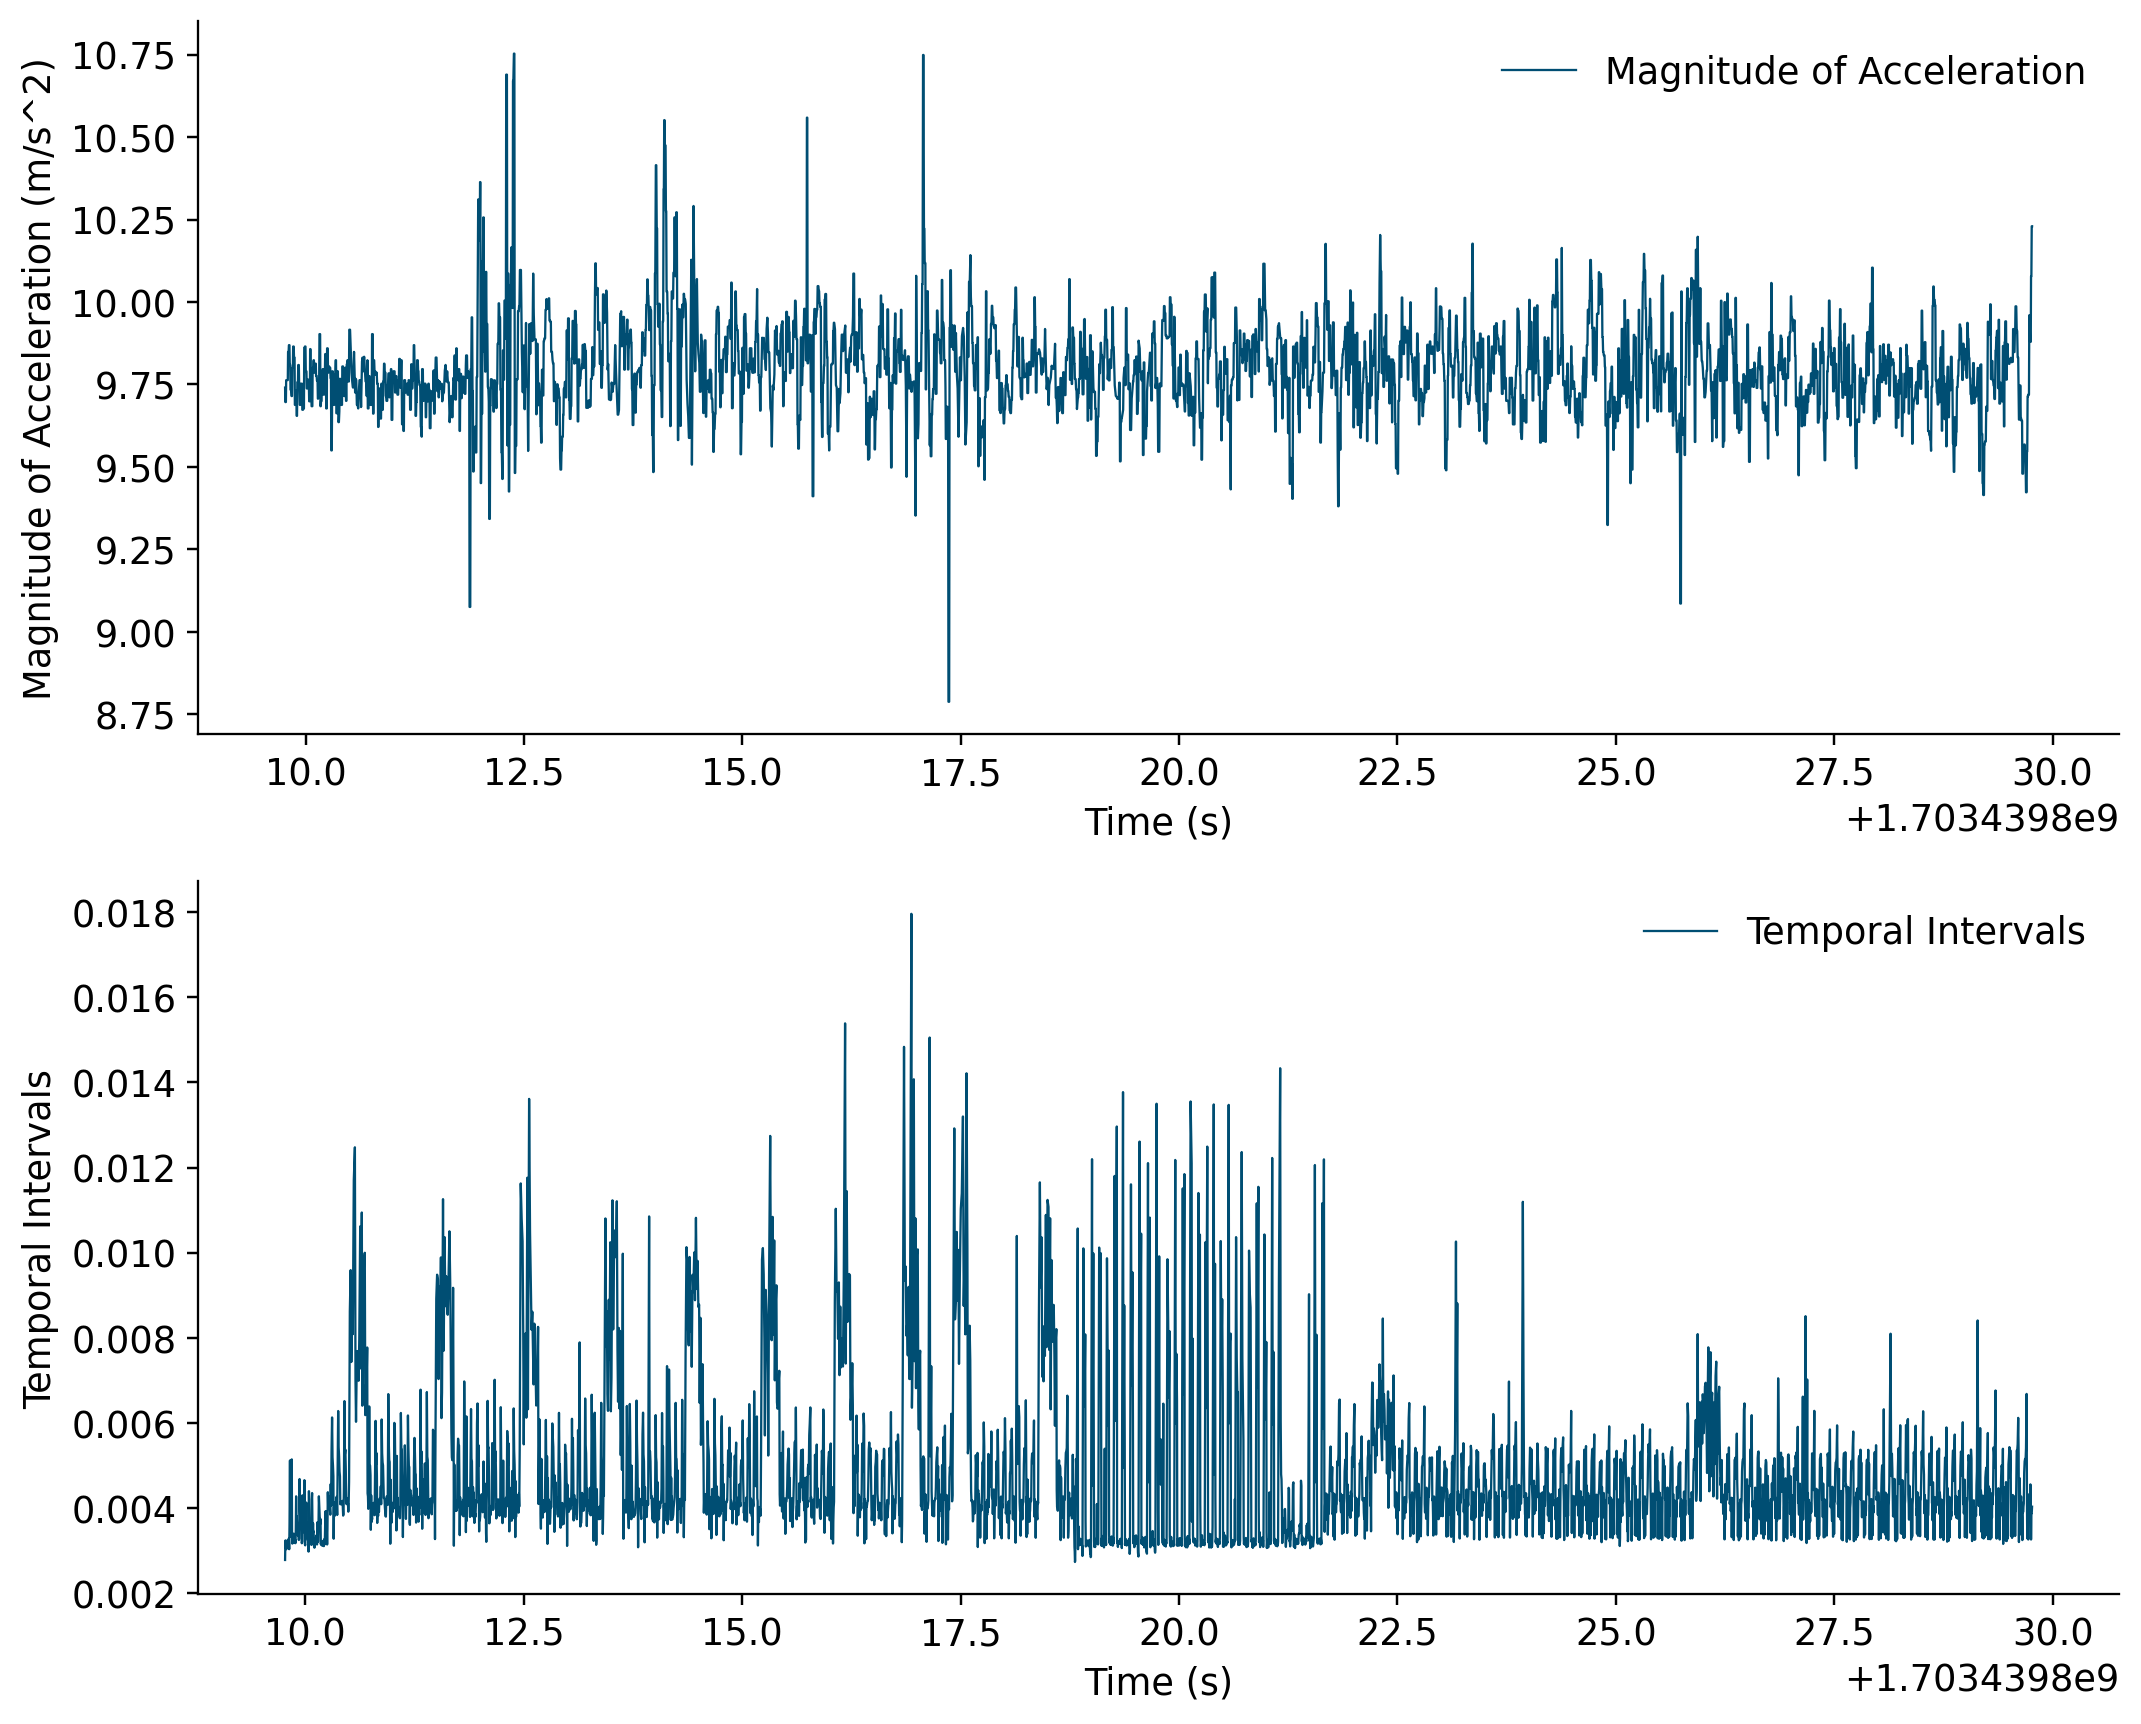

In [6]:
# Calculate the temporal intervals
time_intervals = np.diff(time)

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot magnitude of acceleration over time
ax1.plot(time, absolute_value_acceleration, label='Magnitude of Acceleration')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Magnitude of Acceleration (m/s^2)')
ax1.legend()

#plt.xlim([0,20])
# Plot temporal intervals over time
ax2.plot(time[1:], time_intervals, label='Temporal Intervals')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Temporal Intervals')
ax2.legend()

plt.tight_layout()
plt.show()

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
#with h5py.File(file_path, "r") as h5_file:
   # timestamp_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]
   # time = np.array(timestamp_dataset)
   # print(time)
    
interp_time, interp_data = interpolation(time, absolute_value_acceleration)

# Drucken Sie die Ergebnisse oder visualisieren Sie sie
print("Interpolierte Zeit:", interp_time)
print("Interpolierte Daten:", interp_data)


Interpolierte Zeit: [1.70343981e+09 1.70343981e+09 1.70343981e+09 ... 1.70343983e+09
 1.70343983e+09 1.70343983e+09]
Interpolierte Daten: [ 9.7404474   9.69651084  9.69651084 ... 10.07795406 10.2091705
 10.2297227 ]


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


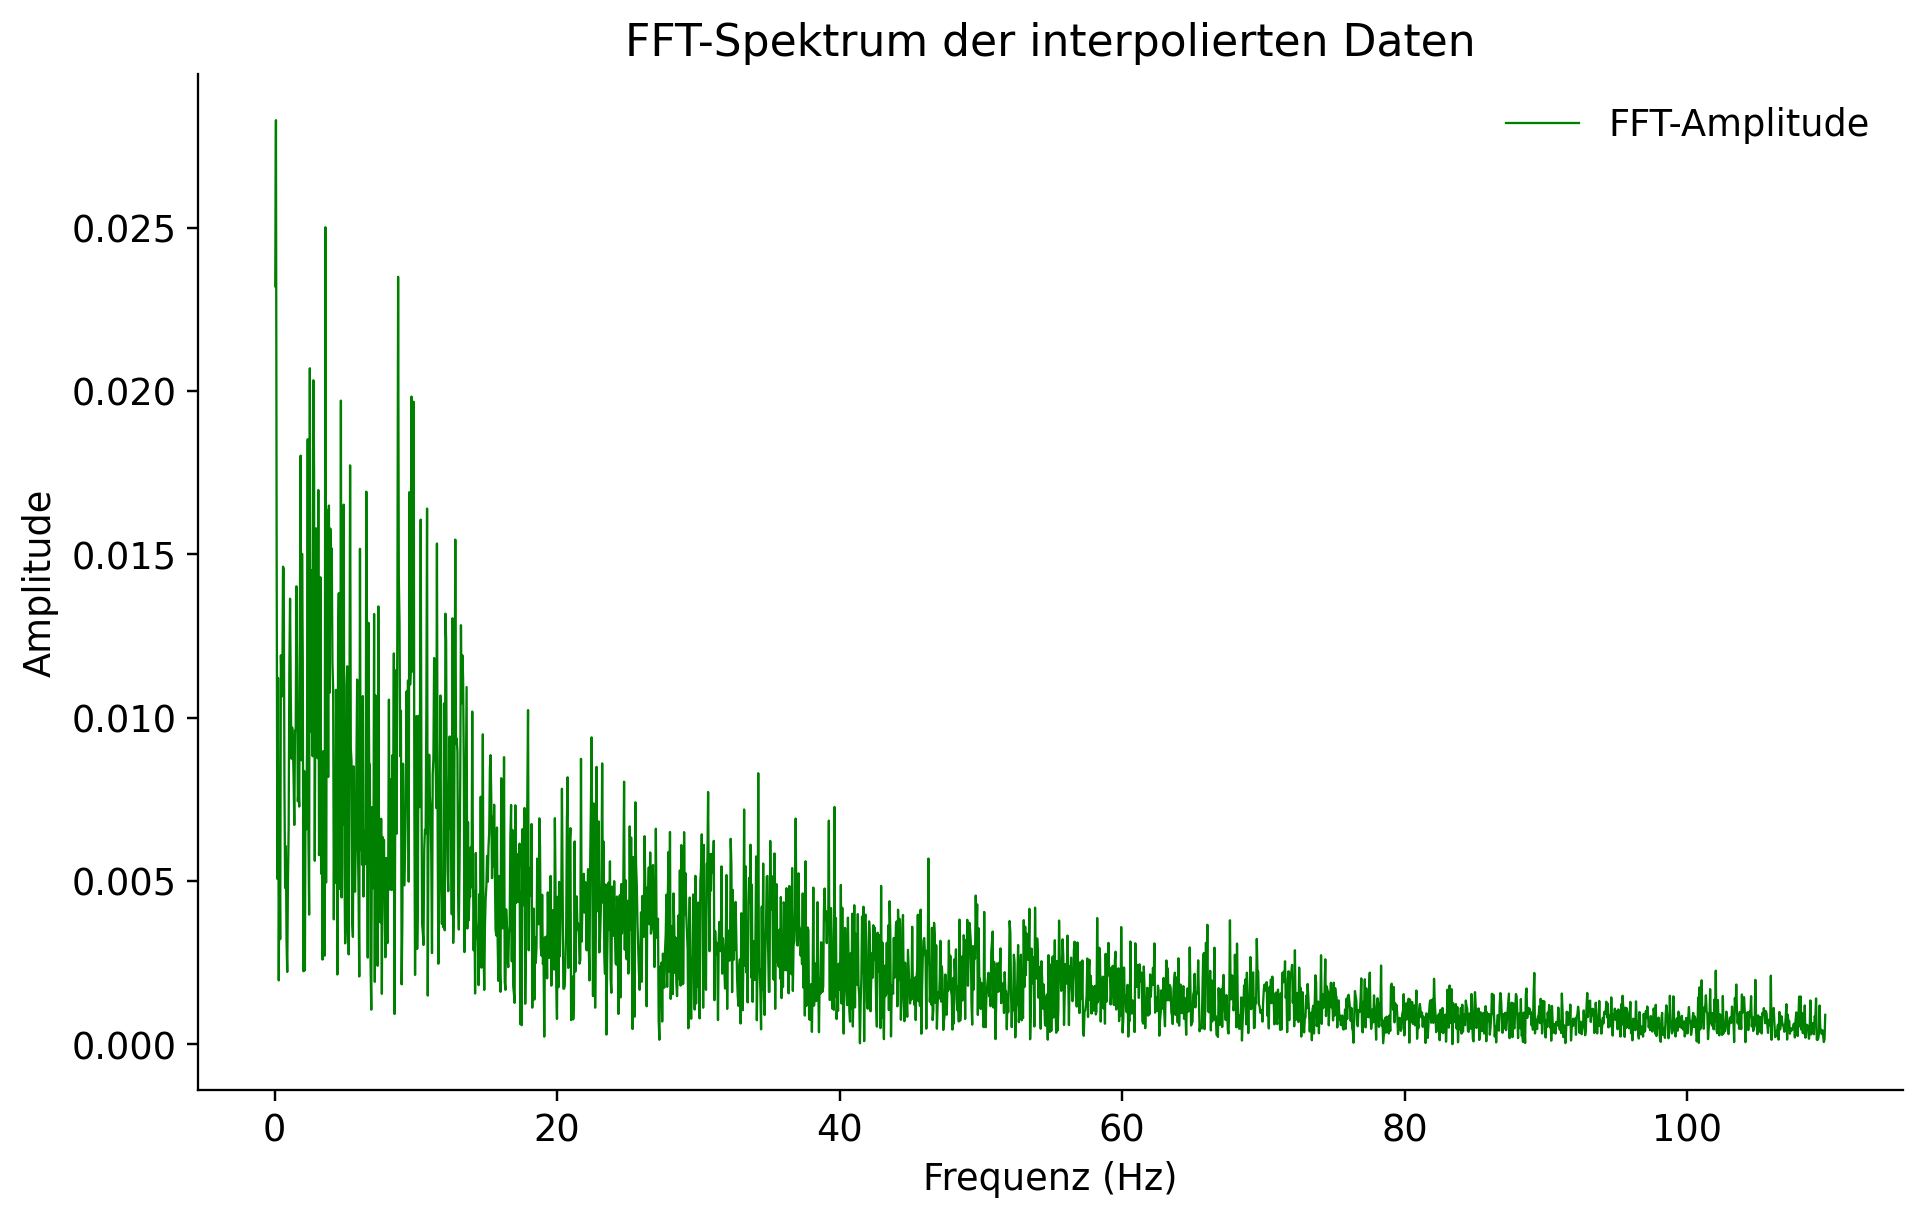

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.


# Berechnen Sie die FFT der interpolierten Daten
fft_amplitude, fft_frequencies = my_fft(interp_data, interp_time)

# Plot der Ergebnisse
plt.figure(figsize=(10, 6))

# Plot der Amplitude des FFT-Spektrums
plt.plot(fft_frequencies, fft_amplitude, label='FFT-Amplitude', color='green')
#plt.ylim([0,100])
#plt.xlim([0,100])
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT-Spektrum der interpolierten Daten')
plt.legend()
#plt.grid(True)
plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="WIN_20231224_16_51_49_Pro.jpg" width="500">

- Beschreibung des Aufbaus:Der Sensor wurde auf dem Handy gelegt.
- Vorgangsbeschreibung:Die handy vibrations wurden aktiviert während der Mesung.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:
path_measurement_folder = "measurement_data/data_20231224_184122_MahmoudAmmash_mobile" # replace None by the relative path to the first object's folder
h5_file_name = "measurement_data/data_20231224_184122_MahmoudAmmash_mobile.h5" # replace None by the filename of the hdf5-file
file_path= "measurement_data/data_20231224_184122_MahmoudAmmash_mobile/data_20231224_184122_MahmoudAmmash_mobile.h5" 


(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231224_184122_MahmoudAmmash_mobile/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231224_184122_MahmoudAmmash_mobile/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231224_184122_MahmoudAmmash_mobile/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eea25c4-0492-6a62-877b-39841a95f612": {
    "type": "probe",
    "name": "mobile",
    "comment": "",
    "path": "measurement_data

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [15]:
with h5py.File(file_path, "r") as h5_file:
    # Access the datasets under the sensor UUID group
    x_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_x"]
    y_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_y"]
    z_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/acceleration_z"]
    timestamp_dataset = h5_file[f"RawData/1ee847be-fddd-6ee4-892a-68c4555b0981/timestamp"]


    # Read data into NumPy arrays
    time = np.array(timestamp_dataset)
    acceleration_x = np.array(x_dataset)
    acceleration_y = np.array(y_dataset)
    acceleration_z = np.array(z_dataset)
    
    print(acceleration_x)
    print(acceleration_y)
    print(acceleration_z)
    print(time-np.min(time))

[0.3530394 0.4314926 0.4314926 ... 2.7850886 2.7850886 2.5889556]
[-2.157463  -2.1966896 -2.1966896 ... -2.3143694 -2.3143694 -1.8044236]
[9.5712904 9.5712904 9.5712904 ... 9.8458766 9.8458766 9.5712904]
[0.00000000e+00 3.09205055e-03 6.39700890e-03 ... 1.99865172e+01
 1.99918919e+01 1.99988256e+01]


#### 2. Betrag der Beschleunigung berechnen


In [16]:
absolute_value_acceleration=get_vec_accel(acceleration_x,acceleration_y,acceleration_z)
print(absolute_value_acceleration)

[ 9.81778403  9.82960991  9.82960991 ... 10.4906773  10.4906773
 10.07810674]


#### 3. Darstellung der Messdaten

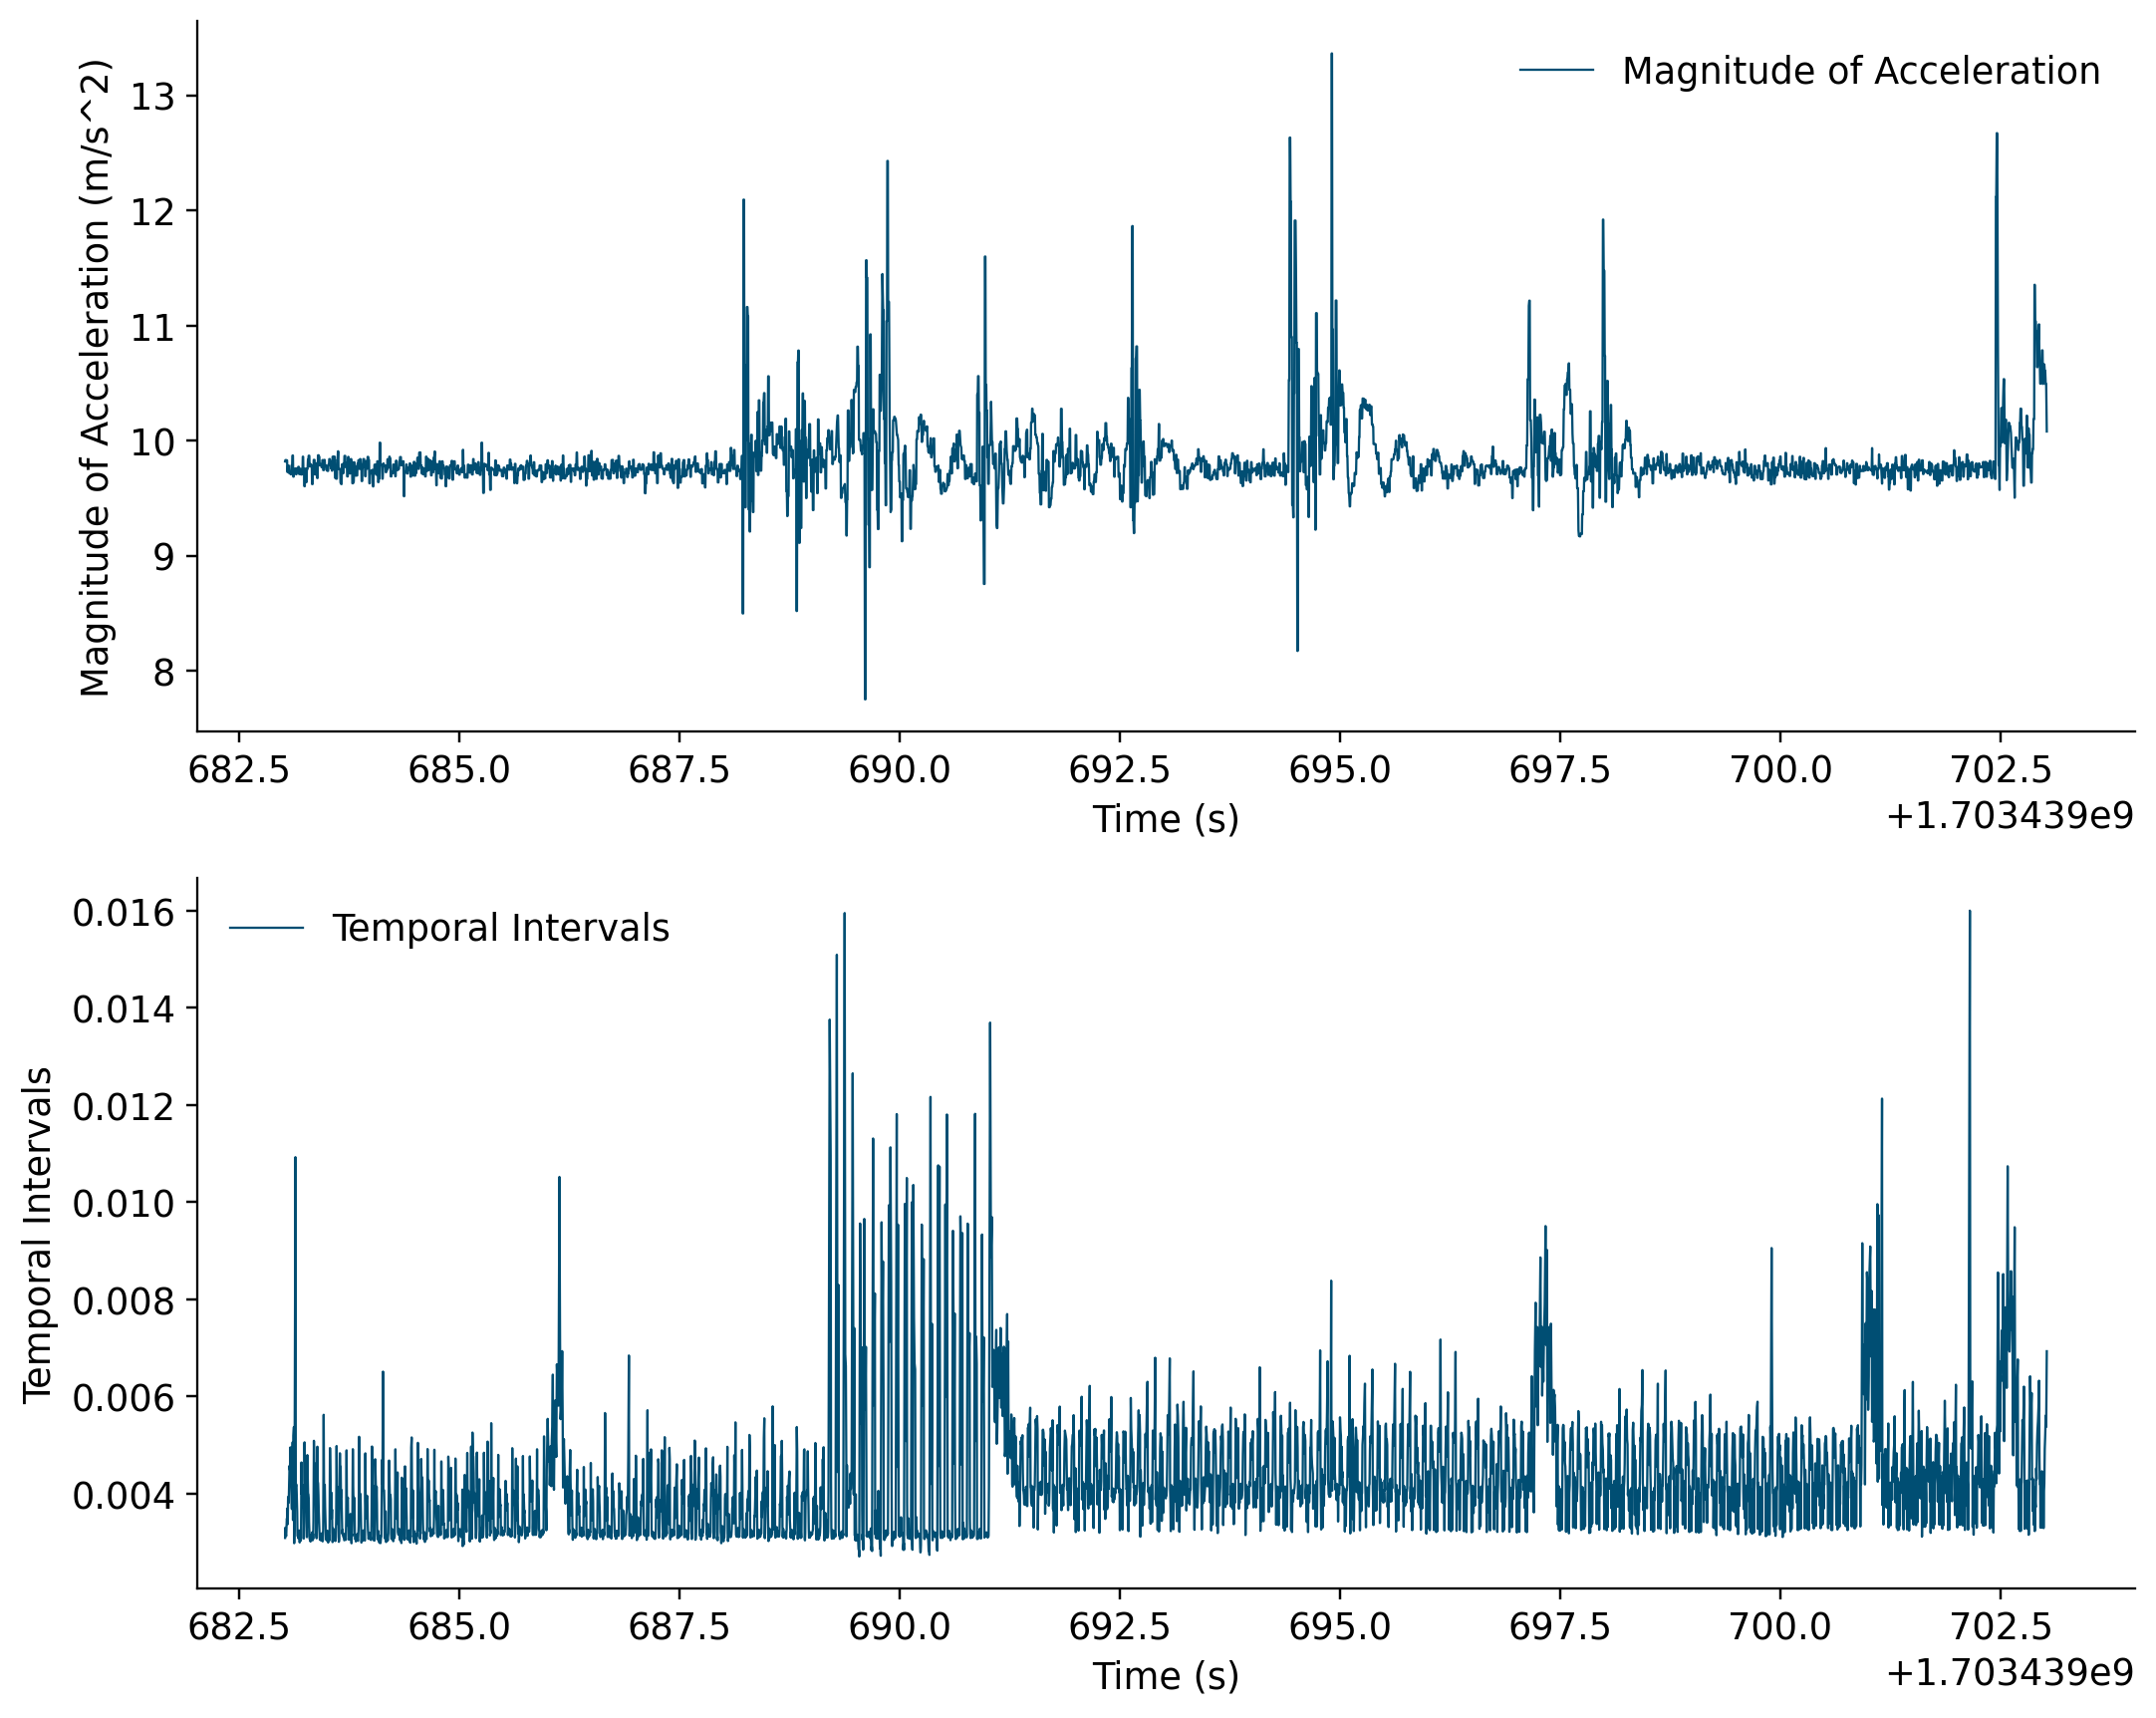

In [17]:
time_intervals = np.diff(time)

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot magnitude of acceleration over time
ax1.plot(time, absolute_value_acceleration, label='Magnitude of Acceleration')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Magnitude of Acceleration (m/s^2)')
ax1.legend()

# Plot temporal intervals over time
ax2.plot(time[1:], time_intervals, label='Temporal Intervals')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Temporal Intervals')
ax2.legend()

plt.tight_layout()
plt.show()

#### 4. Interpolation der Messwerte



In [18]:
interp_time, interp_data = interpolation(time, absolute_value_acceleration)

# Drucken Sie die Ergebnisse oder visualisieren Sie sie
print("Interpolierte Zeit:", interp_time)
print("Interpolierte Daten:", interp_data)


Interpolierte Zeit: [1.70343968e+09 1.70343968e+09 1.70343968e+09 ... 1.70343970e+09
 1.70343970e+09 1.70343970e+09]
Interpolierte Daten: [ 9.81778403  9.82960991  9.82960991 ... 10.4906773  10.32205707
 10.07810674]


#### 5 & 6. FFT durchführen und graphisch darstellen


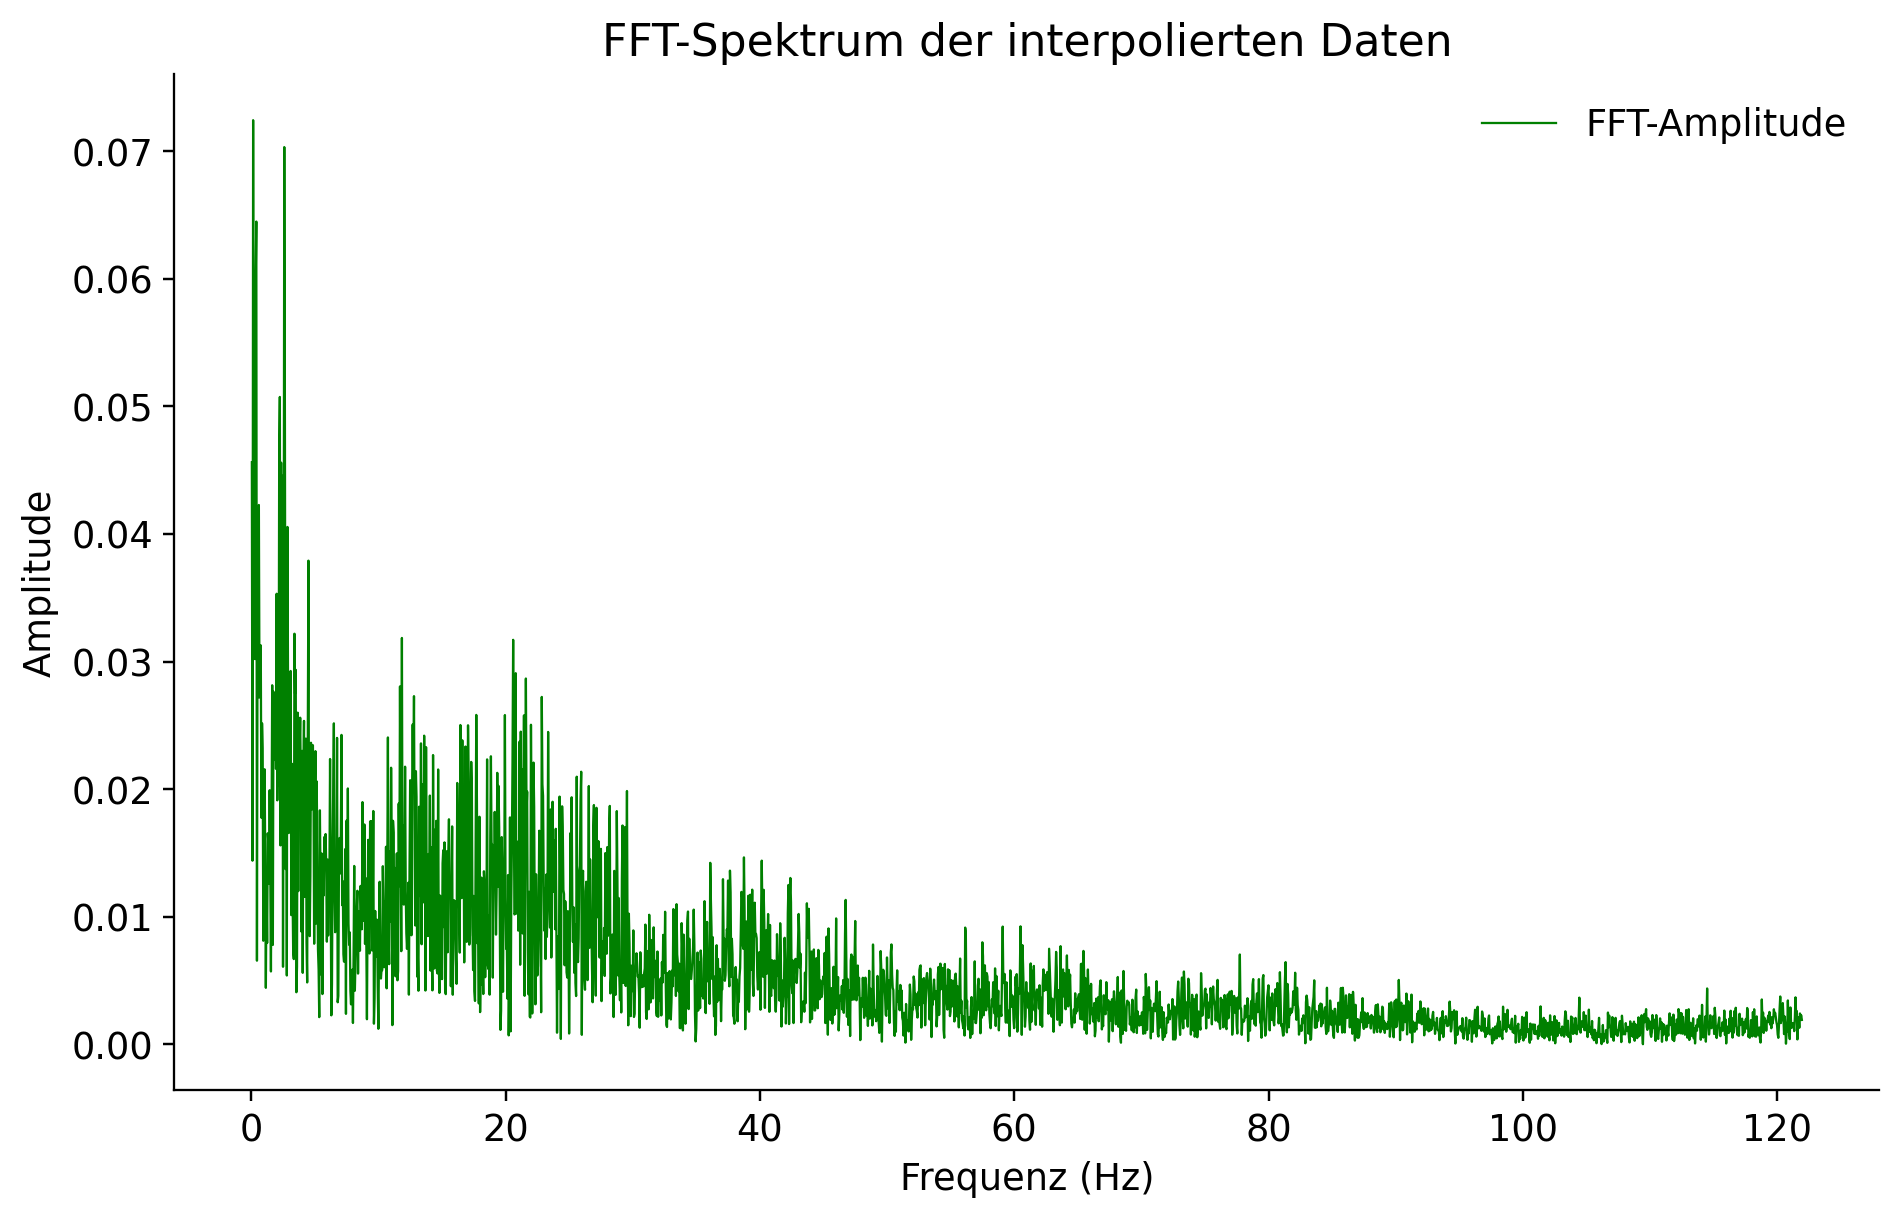

In [19]:
# Berechnen Sie die FFT der interpolierten Daten
fft_amplitude, fft_frequencies = my_fft(interp_data, interp_time)

# Plot der Ergebnisse
plt.figure(figsize=(10, 6))

# Plot der Amplitude des FFT-Spektrums
plt.plot(fft_frequencies, fft_amplitude, label='FFT-Amplitude', color='green')
#plt.ylim([0,1])
#plt.xlim([0,100])
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT-Spektrum der interpolierten Daten')
plt.legend()
#plt.grid(True)
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Ja , messdaten wurden sinvoll ausgewertet , und die interpolierte Daten haben einen wesentlichen Effekt ausgegeben.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Ich habe richtig wichtige Skills gelernt .Es wäre bisschen schöner gewesen wenn wir selbst die FFT messung Funktion implementieren müssen.